In [1]:
import os
import sys

# Function to Traverse up until you find the project root
def get_project_root(target="Decoding-Human-Activity-Erdos-Summer-2025"): # replace target name with the name of the root directory/repository name
    path = os.getcwd()
    while os.path.basename(path) != target:
        new_path = os.path.dirname(path)
        if new_path == path:
            raise FileNotFoundError(f"Could not find project root '{target}'.")
        path = new_path
    return path


project_root = get_project_root()
directory_path = os.path.join(project_root, "Python Files") 

# Add to Python path
if directory_path not in sys.path:
    sys.path.append(directory_path)

from utils import *  # * import all or specific functions

# Feature Selection with Random Forest

**Sensitivity Sweep with Random Forest**

First, we fit a Random Forest on all 561 raw features to compute each feature’s importance.  We then sort features by importance, pick the top $N$, and measure leave-one-out 1-NN accuracy on those.  By sweeping $N$ from small to large, we can see how many features are really needed to maintain high classification performance.


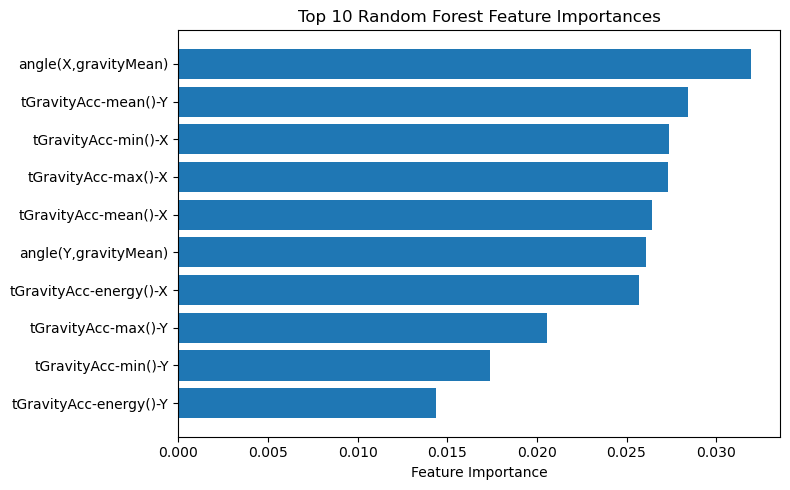

In [2]:
X_rf = uci_df.drop(columns=['subject','activity']).values
y_rf = uci_df['activity'].values

rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_rf, y_rf)

feat_names = uci_df.columns.drop(['subject','activity'])
importances = rf.feature_importances_
idx_sorted  = np.argsort(importances)[::-1]

top_n = 10
indices = np.argsort(importances)[::-1][:top_n]

top_names  = feat_names[indices]
top_values = importances[indices]

plt.figure(figsize=(8, 5))
plt.barh(range(top_n), top_values[::-1], align='center')
plt.yticks(range(top_n), top_names[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Random Forest Feature Importances')
plt.tight_layout()
plt.show()


In [3]:
topn_list   = np.arange(5, 562, 5)
rf_to_acc   = {}
feat_names  = uci_df.columns.drop(['subject','activity']).to_numpy()
importances = rf.feature_importances_
idx_sorted  = np.argsort(importances)[::-1]

for topn in topn_list:
    # pick the top‐N features
    top_idx      = idx_sorted[:topn]
    top_features = feat_names[top_idx].tolist()

    # grab the *entire* dataset with those features
    X = uci_df[top_features].values
    y = uci_df['activity'].values

    # do Leave‐one‐out 1‐NN via KD‐tree
    nbrs      = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(X)
    _, inds   = nbrs.kneighbors(X)
    nn        = inds[:,1]                    
    acc       = np.mean(y[nn] == y)

    rf_to_acc[topn] = acc

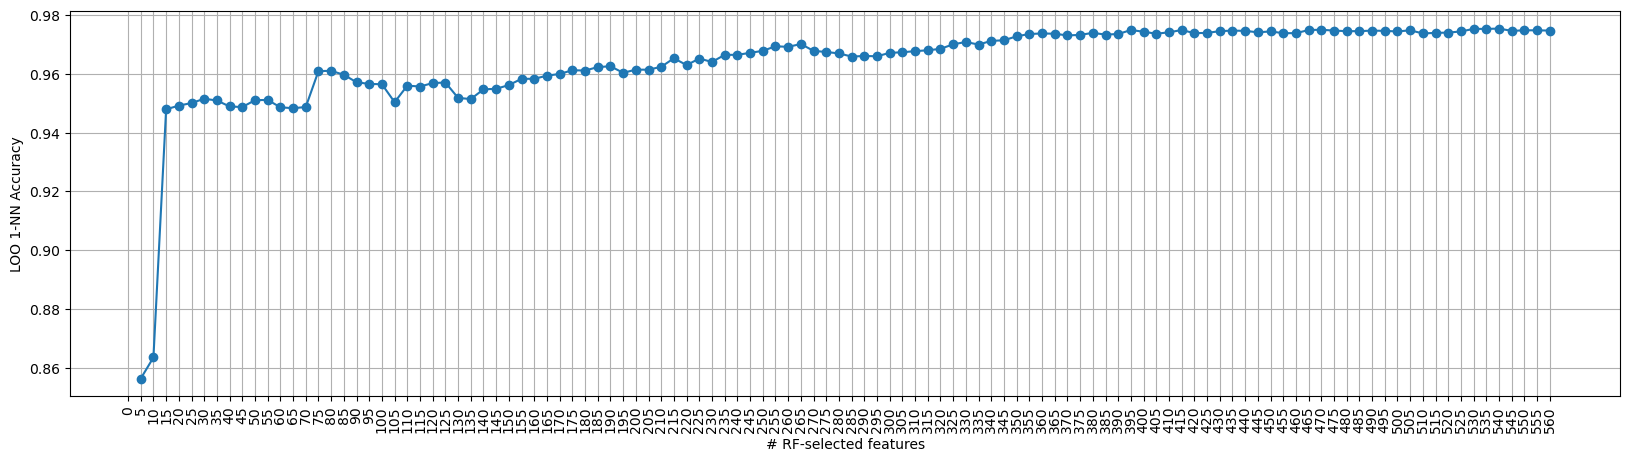

In [4]:
#plot
Ns   = sorted(rf_to_acc.keys())
accs = [rf_to_acc[n] for n in Ns]
plt.figure(figsize=(20,5))
plt.plot(Ns, accs, '-o')
plt.xlabel('# RF-selected features')
plt.xticks(list(range(0,561,5)),rotation = 90)
plt.ylabel('LOO 1-NN Accuracy')
plt.grid(True)
plt.show()

As the RF‐sweep shows, using just the **top 20** features (out of 561) still yields about **95 %** LOO 1-NN accuracy.

# Dimension Reduction PCA

**Sensitivity Sweep with PCA**

Secondly, instead of picking individual features as in our Random Forest approach, here we use **Principal Component Analysis (PCA)** to project the 561-dimensional data onto a lower-dimensional subspace. Each new axis (principal component) is a linear combination of the original features that captures as much variance as possible. By varying the number of components, we can see how many dimensions are needed to recover high 1-NN accuracy.


### On the full data

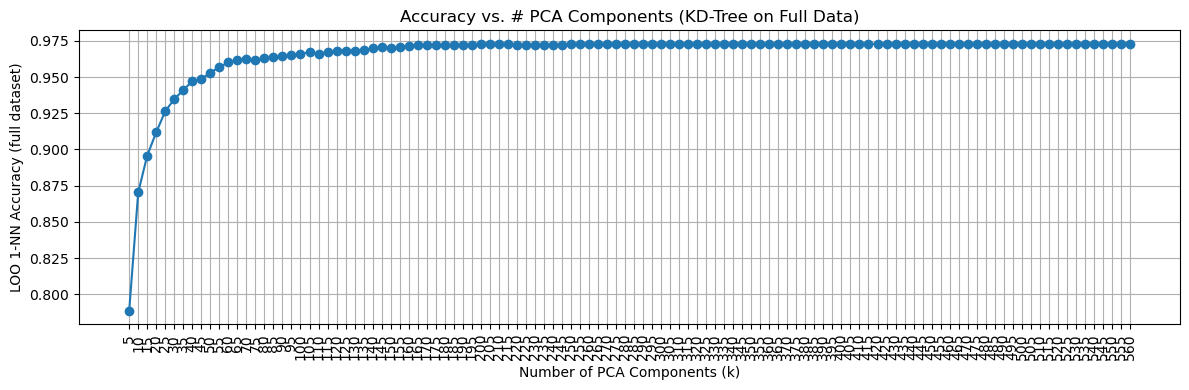

In [5]:
feature_cols = [c for c in uci_df.columns if c not in ('subject','activity')]
X_raw = uci_df[feature_cols].values
y_all = uci_df['activity'].values

# Standardize
scaler = StandardScaler().fit(X_raw)
X_scaled = scaler.transform(X_raw)

pca = PCA().fit(X_scaled)
X_pca_full = pca.transform(X_scaled)  

pc_cols = [f'PC{i}' for i in range(1, X_pca_full.shape[1]+1)]
df_pca = pd.DataFrame(X_pca_full, columns=pc_cols, index=uci_df.index)
df_pca['subject']  = uci_df['subject']
df_pca['activity'] = uci_df['activity']

topk_list = list(range(5, 561, 5))
pc_to_acc  = {}
y_all      = df_pca['activity'].values

for k in topk_list:
    use_cols = pc_cols[:k]
    Xk       = df_pca[use_cols].values
    yk       = y_all

    # build KD‐tree and query 2 neighbors (self + true NN)
    nbrs      = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(Xk)
    _, inds   = nbrs.kneighbors(Xk)
    nn_idx    = inds[:, 1]         # index of nearest *other* sample

    # compute LOO-1NN accuracy
    acc = np.mean(yk[nn_idx] == yk)
    pc_to_acc[k] = acc




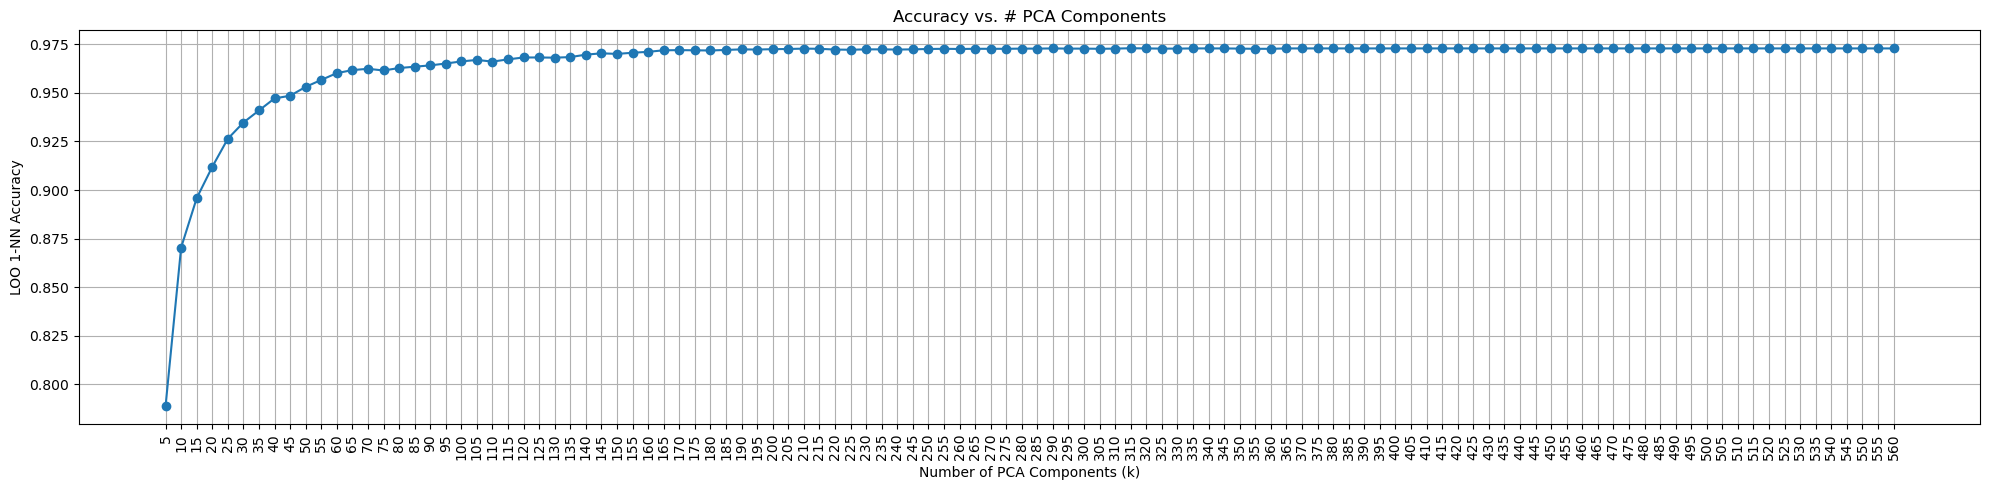

In [8]:
# plot
Ks   = sorted(pc_to_acc.keys())
accs = [pc_to_acc[k] for k in Ks]

plt.figure(figsize=(20,5))
plt.plot(Ks, accs, '-o')
plt.xlabel('Number of PCA Components (k)')
plt.ylabel('LOO 1-NN Accuracy')
plt.title('Accuracy vs. # PCA Components')
plt.grid(True)
plt.xticks(Ks, rotation=90)
plt.tight_layout()
plt.show()

### on the reduced data by sampling 1200 samples

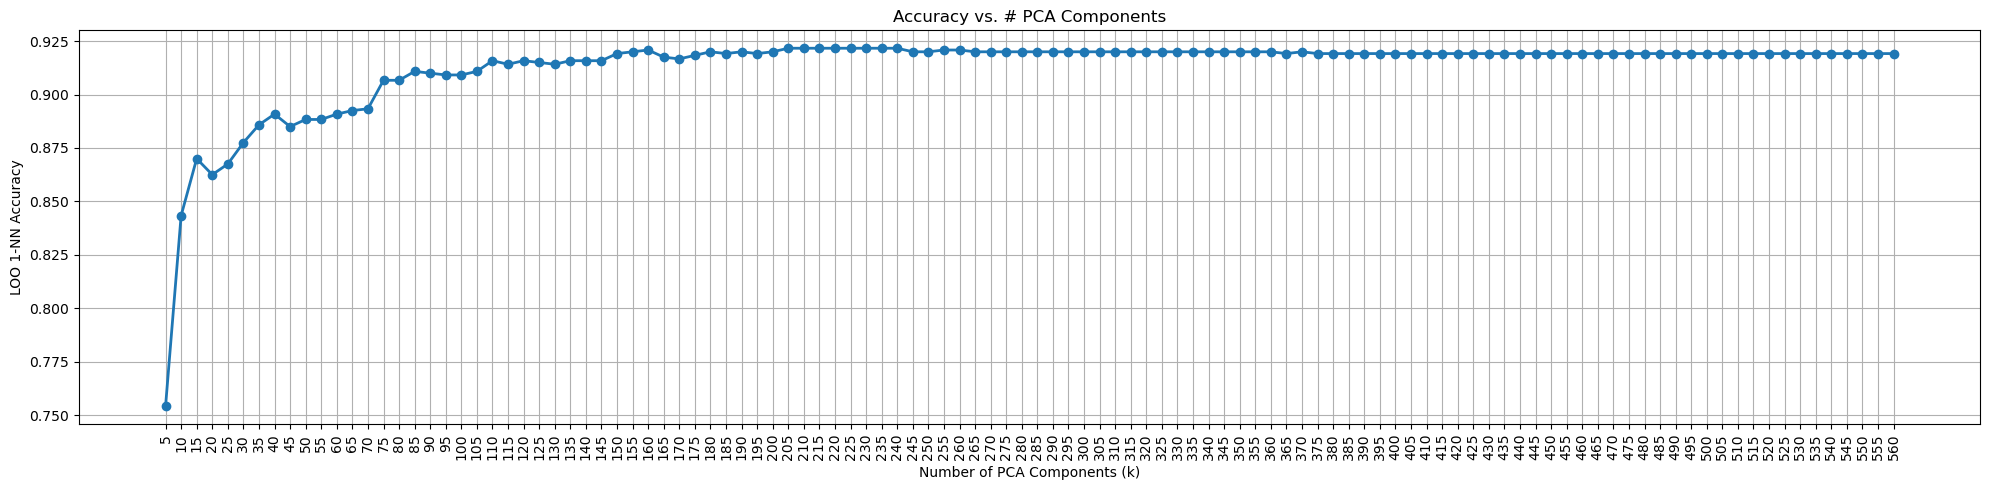

In [11]:
feature_cols = [c for c in uci_df.columns if c not in ('subject','activity')]
X_raw = uci_df[feature_cols].values
y_all = uci_df['activity'].values

# Standardize
scaler = StandardScaler().fit(X_raw)
X_scaled = scaler.transform(X_raw)


pca = PCA().fit(X_scaled)
X_pca_full = pca.transform(X_scaled)  


pc_cols = [f'PC{i}' for i in range(1, X_pca_full.shape[1]+1)]
df_pca = pd.DataFrame(X_pca_full, columns=pc_cols, index=uci_df.index)
df_pca['subject']  = uci_df['subject']
df_pca['activity'] = uci_df['activity']

#  Loop over different # of PCs and compute LOO 1-NN accuracy ---
topk_list   = list(range(5, 561, 5))     # e.g. 5,10,…,100 PCs
N           = 1200                       # total subsample size
C           = df_pca['activity'].nunique()
n_per_class = N // C

pc_to_acc = {}
for k in topk_list:
    # take only the first k PCs
    use_cols = pc_cols[:k]
    df_sub   = df_pca[['subject','activity'] + use_cols]
    
    # stratified sample equal per activity
    df_strat = (
        df_sub
          .groupby('activity', group_keys=False)
          .sample(n=n_per_class, random_state=42)
          .reset_index(drop=True)
    )
    
    # extract X and y
    Xk = df_strat[use_cols].values
    yk = df_strat['activity'].tolist()
    
    # compute LOO 1-NN accuracy
    acc = loo_euclidean_1nn_accuracy(Xk, yk)
    pc_to_acc[k] = acc

# --- 3) Plot the result ---
Ks   = sorted(pc_to_acc.keys())
accs = [pc_to_acc[k] for k in Ks]

plt.figure(figsize=(20,5))
plt.plot(Ks, accs, marker='o', linewidth=2)
plt.xlabel('Number of PCA Components (k)')
plt.ylabel('LOO 1-NN Accuracy')
plt.title('Accuracy vs. # PCA Components')
plt.grid(True)
plt.xticks(Ks, rotation=90)
plt.tight_layout()
plt.show()


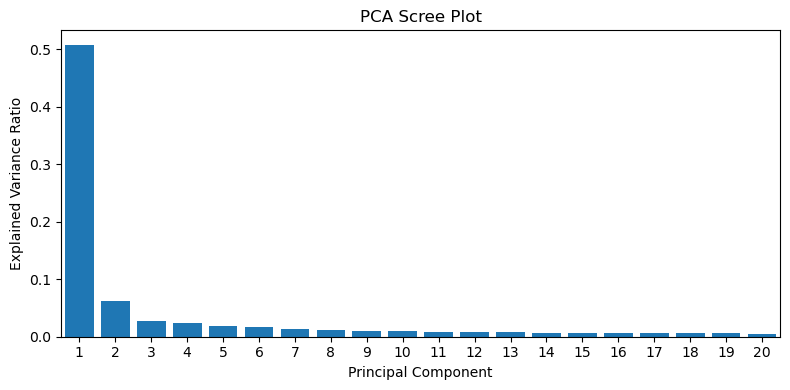

In [19]:
evr = pca.explained_variance_ratio_

plt.figure(figsize=(8,4))
plt.bar(np.arange(1, len(evr)+1), evr, width=0.8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot')
plt.xlim(0.5, 20.5)          # zoom into the first 20 PCs if you like
plt.xticks(np.arange(1,21))  # show ticks 1–20
plt.tight_layout()
plt.show()

The very first PC already captures half of the variability in the features.

# Dimension Reduction LDA

Lastly, we perform Linear Discriminant Analysis (LDA) which finds a projection matrix $W \in \mathbb{R}^{561 \times d}$ whose columns are the top $d$ directions $w$ that **maximize class separability**. More specifically, this is done by optimizing:
$$\max_{w}\;\frac{w^\top S_B\,w}{w^\top S_W\,w}
$$
where
$$
S_B = \sum_{c} n_c\,(\mu_c - \mu)(\mu_c - \mu)^\top,
\quad
S_W = \sum_{c}\sum_{x_i \in c}(x_i - \mu_c)(x_i - \mu_c)^\top.
$$



Recall that to classify each class, we look at its nearest neighbor (measured by Euclidean distance). To ease computation, we build a KD-Tree and then query each point's nearest neighbor.

LDA chooses its axes to pull classes as far apart as possible. As we can see from above, with only using 5 LDA components, our method is able to classify with an accuracy of just below 98%. 

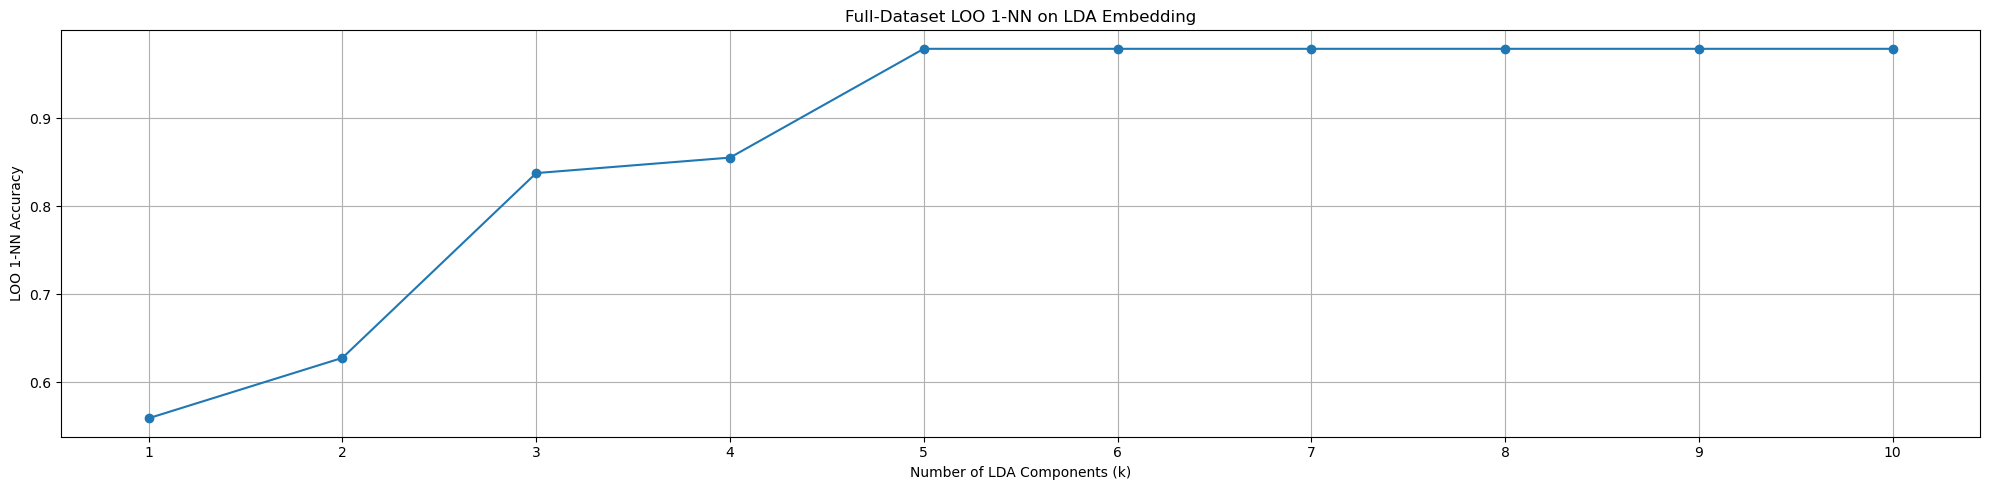

Accuracy score with 5 LDA components = 0.9787357995921934


In [14]:
X = uci_df.drop(columns=['subject','activity']).values
y = uci_df['activity'].values
# Fit LDA on the full data first
lda = LDA(n_components=None)  # fit with max components possible (C-1)
X_lda_full = lda.fit_transform(X, y)

# Prepare df_lda DataFrame including subject, activity and LDA components
lda_cols = [f"LDA_{i+1}" for i in range(X_lda_full.shape[1])]
df_lda = uci_df[['subject','activity']].copy()
for i, col in enumerate(lda_cols):
    df_lda[col] = X_lda_full[:, i]

lda_cols = [c for c in df_lda.columns if c.startswith("LDA_")]
topk_list = list(range(1, 10+1))  # 1 through max LDA dims

lda_to_acc = {}
for k in topk_list:
    # 1) Pick first k LDA dims
    use_cols = lda_cols[:k]
    Xk = df_lda[use_cols].values
    yk = df_lda['activity'].values

    # 2) Build KD‐tree & query 2 neighbors (self + true 1‐NN)
    nbrs     = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(Xk)
    distances, indices = nbrs.kneighbors(Xk)

    # 3) indices[:,0] is self, indices[:,1] is the real NN
    nn_idx = indices[:,1]

    # 4) LOO accuracy = fraction whose neighbor has the same label
    acc = np.mean(yk[nn_idx] == yk)
    lda_to_acc[k] = acc

# --- plot ---
Ks   = list(lda_to_acc.keys())
accs = [lda_to_acc[k] for k in Ks]

plt.figure(figsize=(20,5))
plt.plot(Ks, accs, '-o')
plt.xlabel('Number of LDA Components (k)')
plt.ylabel('LOO 1-NN Accuracy')
plt.title('Full‐Dataset LOO 1-NN on LDA Embedding')
plt.grid(True)
plt.xticks(Ks)
plt.tight_layout()
plt.show()

print(f"Accuracy score with 5 LDA components = {accs[4]}")

From the 3D projection below, we can easily see that the data is clustered clearly. In particular, laying is perfectly isolated. However, we also observe that standing and sitting are lumped together. This will be observed in the confusion matrix as well.

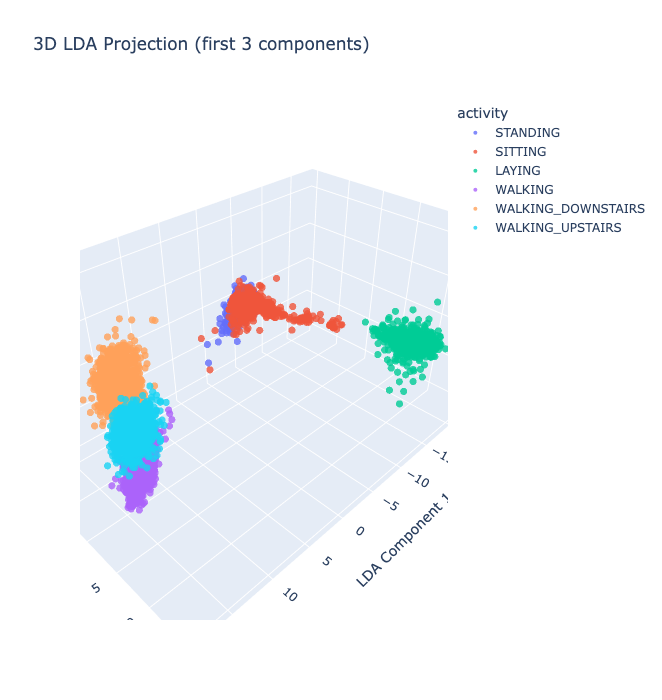

In [20]:
fig = px.scatter_3d(
    df_lda,
    x='LDA_1',
    y='LDA_2',
    z='LDA_3',
    color='activity',
    title='3D LDA Projection (first 3 components)',
    labels={
        'LDA_1': 'LDA Component 1',
        'LDA_2': 'LDA Component 2',
        'LDA_3': 'LDA Component 3'
    },
    width=1200,
    height=700
)
fig.update_traces(marker=dict(size=4, opacity=0.8))
fig.show()


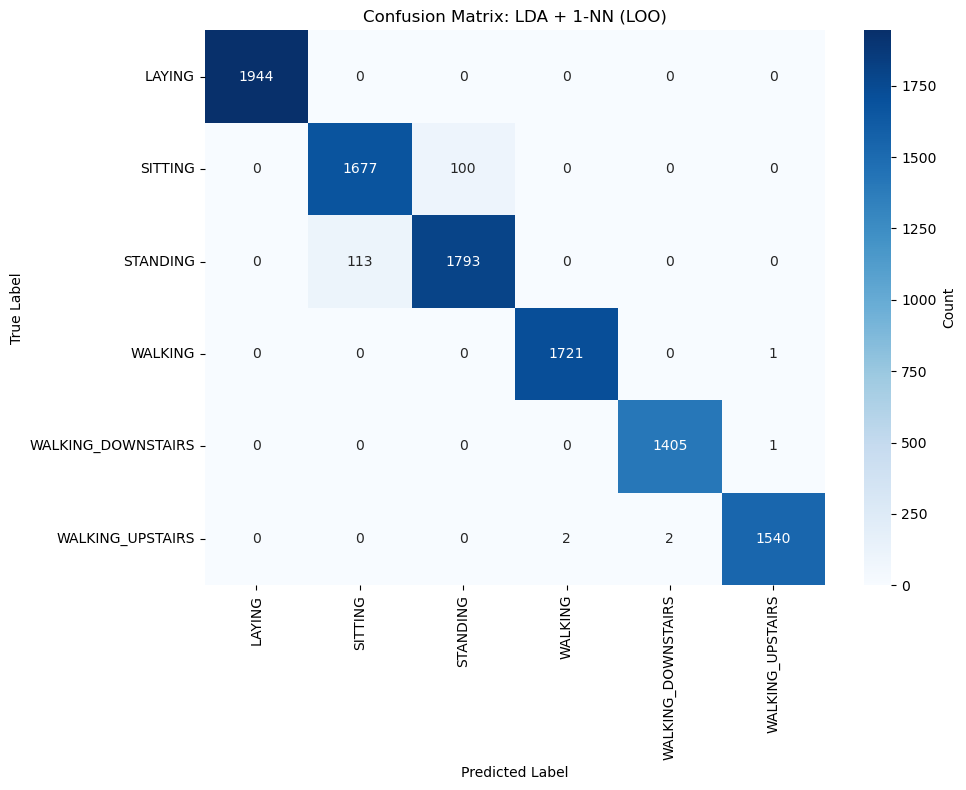

In [32]:
nbrs     = NearestNeighbors(n_neighbors=2).fit(X_lda_full)
_, inds  = nbrs.kneighbors(X_lda_full)
nn_index = inds[:,1]               # skip self

y_true = y
y_pred = y[nn_index]

# 2) compute confusion matrix
labels = np.unique(y_true)
cm = confusion_matrix(y_true, y_pred, labels=labels)

# 3) plot with seaborn
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(10,8))
sns.heatmap(
    df_cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: LDA + 1-NN (LOO)')
plt.tight_layout()
plt.savefig(f"lda_confusion_matrix.png",bbox_inches = 'tight')
plt.show()


# Orientation Invariance under axis-permutations

In [18]:
uci_df

,subject,activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,1,STANDING,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,1,STANDING,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,1,STANDING,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,1,STANDING,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,1,STANDING,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,24,WALKING_UPSTAIRS,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,...,0.074472,-0.376278,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784
10295,24,WALKING_UPSTAIRS,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,...,0.101859,-0.320418,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412
10296,24,WALKING_UPSTAIRS,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,...,-0.066249,-0.118854,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184
10297,24,WALKING_UPSTAIRS,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,...,-0.046467,-0.205445,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563


The current features displayed above assume a fixed orientation of the smartphone device. For example, if the device is held as shown in [this video](http://www.youtube.com/watch?v=XOEN9W05_4A) (when the subject is standing), then:

- The $x$-axis corresponds to the **up-down** direction,
- The $y$-axis corresponds to the **forward-backward** direction, and
- The $z$-axis corresponds to the **left-right** direction.

Our method classifies different activities based on features extracted under this fixed orientation. As a result, the classification task may be too easy due to this consistency in device placement. However, in real-world scenarios, users are unlikely to keep their phones in a fixed orientation. This raises the question: **Will our approach remain effective when the phone orientation varies?**

To explore this, we propose to test the model’s robustness by permuting the axes of the feature set. Specifically, we will permute the $x$, $y$, and $z$ axes of all features (e.g., mean, standard deviation, median absolute deviation, etc.) to simulate alternative phone orientations. For example, swapping the $x$ and $y$ axes would mimic the effect of holding the phone in a vertical rather than horizontal orientation.

This synthetic experiment will help us evaluate how sensitive the current model is to changes in device orientation.


In [39]:
import re
df = uci_df.copy() 

# STEP 1: Automatically get all 3D prefixes
xyz_cols = [col for col in df.columns if re.search(r'-[XYZ]$', col)] 

feature_prefixes = set() # will consist of prefixes (without XYZ) e.g. tBodyAcc-mean() 
for col in xyz_cols:
    match = re.match(r'(.+)-[XYZ]$', col) # does col end with X, Y or Z. 
    if match: # if col ends with X, Y or Z match.group(1) gives the name before the -[XYZ] e.g. tBodyAcc-mean() for tBodyAcc-mean()-X
        feature_prefixes.add(match.group(1)) # add this to the set
feature_prefixes = sorted(feature_prefixes)

axes = ['X', 'Y', 'Z']


# STEP 2: Build a mapping from feature_prefix -> axis -> column name
feature_map = {}
for prefix in feature_prefixes:
    feature_map[prefix] = {ax: f"{prefix}-{ax}" for ax in axes if f"{prefix}-{ax}" in df.columns}
    # If any axis is missing, skip this feature
    if len(feature_map[prefix]) != 3:
        del feature_map[prefix]



# STEP 3: Apply a random permutation row-by-row
shuffled_df = df.copy()
for i in range(len(df)): # for each row, we will randomly permuate x,y and z.
    perm = np.random.permutation(axes)  # e.g. ['Y','X','Z'] or ['Z','Y','X'] etc.
    for prefix, axis_map in feature_map.items():
        # Original values in X,Y,Z order
        orig_values = [df.at[i, axis_map[ax]] for ax in axes]
        # Permuted values, assign to shuffled_df
        for idx, ax in enumerate(axes):
            shuffled_df.at[i, axis_map[ax]] = orig_values[perm.tolist().index(ax)]



# remove any "-X", "-Y" or "-Z" at the end of the column name
shuffled_df.columns = shuffled_df.columns.to_series().replace(
    to_replace=r'-(?:X|Y|Z)$',
    value='',
    regex=True
)


shuffled_df


,subject,activity,tBodyAcc-mean(),tBodyAcc-mean(),tBodyAcc-mean(),tBodyAcc-std(),tBodyAcc-std(),tBodyAcc-std(),tBodyAcc-mad(),tBodyAcc-mad(),...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,1,STANDING,-0.132905,0.288585,-0.020294,-0.913526,-0.995279,-0.983111,-0.923527,-0.995112,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,1,STANDING,-0.016411,0.278419,-0.123520,-0.975300,-0.998245,-0.960322,-0.974914,-0.998807,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,1,STANDING,-0.113462,0.279653,-0.019467,-0.978944,-0.995380,-0.967187,-0.977469,-0.996520,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,1,STANDING,-0.123283,0.279174,-0.026201,-0.990675,-0.996091,-0.983403,-0.989302,-0.997099,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,1,STANDING,-0.115362,0.276629,-0.016570,-0.990482,-0.998139,-0.980817,-0.990441,-0.998321,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,24,WALKING_UPSTAIRS,-0.053391,-0.099109,0.310155,-0.140589,-0.215088,-0.287866,-0.148775,-0.232057,...,0.074472,-0.376278,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784
10295,24,WALKING_UPSTAIRS,-0.039214,-0.105915,0.363385,0.028148,-0.196373,-0.305388,-0.030036,-0.270237,...,0.101859,-0.320418,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412
10296,24,WALKING_UPSTAIRS,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,...,-0.066249,-0.118854,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184
10297,24,WALKING_UPSTAIRS,-0.096499,0.018467,0.237594,-0.207574,-0.229775,-0.323114,-0.289477,-0.279610,...,-0.046467,-0.205445,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563


Above, we see the shuffled dataset where in each row x,y, and z axis are randomly permutated as explained before. We now perform LDA + 1NN Classifier on this shuffled data. We use LOO cv again to validate. Despite this shuffling, the classification score only dropped less than 1%.

In [38]:
X_shuffled = shuffled_df.drop(columns=['subject','activity']).values
y_shuffled = shuffled_df['activity'].values
# fit LDA
lda = LDA(n_components= 5)
X_shuffled_lda = lda.fit_transform(X_shuffled, y_shuffled)

nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(X_shuffled_lda)
distances, indices = nbrs.kneighbors(X_shuffled_lda)

# indices[:,0] is self, indices[:,1] is the nearest neighbor
nn = indices[:, 1]
accuracy_shuffled = np.mean(y_shuffled[nn] == y_shuffled)
print(f"1-NN LOO accuracy_shuffled: {accuracy_shuffled:.3%}")


1-NN LOO accuracy_shuffled via KD-tree: 97.000%
